### 🔧 环境配置和检查

#### 概述

本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：

- 使用统一的conda环境：激活统一的学习环境
- 通过国内镜像源快速安装依赖：配置pip使用清华镜像源
- 加速模型下载：设置HuggingFace镜像代理
- 检查系统配置：检查硬件和软件配置

#### 配置

- **所需环境及其依赖已经部署好**
- 在`Notebook`右上角选择`jupyter内核`为`python(flyai_agent_in_action)`，即可执行下方代码

In [ ]:
%%script bash

# 1. 激活 conda 环境 (仅对当前单元格有效)
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action

echo "========================================="
echo "== Conda 环境检查报告 (仅针对当前 Bash 子进程) =="
echo "========================================="

# 2. 检查当前激活的环境
CURRENT_ENV_NAME=$(basename $CONDA_PREFIX)

if [ "$CURRENT_ENV_NAME" = "flyai_agent_in_action" ]; then
    echo "✅ 当前单元格已成功激活到 flyai_agent_in_action 环境。"
    echo "✅ 正在使用的环境路径: $CONDA_PREFIX"
    echo ""
    echo "💡 提示: 后续的 Python 单元格将使用 Notebook 当前选择的 Jupyter 内核。"
    echo "   如果需要后续单元格也使用此环境，请执行以下操作:"
    echo "   1. 检查 Notebook 右上角是否已选择 'python(flyai_agent_in_action)'。"
else
    echo "❌ 激活失败或环境名称不匹配。当前环境: $CURRENT_ENV_NAME"
    echo ""
    echo "⚠️ 严重提示: 建议将 Notebook 的 Jupyter **内核 (Kernel)** 切换为 'python(flyai_agent_in_action)'。"
    echo "   (通常位于 Notebook 右上角或 '内核' 菜单中)"
    echo ""
    echo "📚 备用方法 (不推荐): 如果无法切换内核，则必须在**每个**代码单元格的头部重复以下命令:"
    echo ""
    echo "%%script bash"
    echo "# 必须在每个单元格都执行"
    echo "eval \"\$(conda shell.bash hook)\""
    echo "conda activate flyai_agent_in_action"
fi

echo "=========================================" 

In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-4/sub-graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 子图（Sub-graphs）

## 回顾

我们正在逐步构建一个多智能体（multi-agent）研究助理，它把本课程的所有模块串联起来。

上一节我们学习了并行化（parallelization），这是 LangGraph 可控性中的一个重要主题。

## 目标

现在我们将学习[子图](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#simple-example)。

## 状态（State）

子图允许你在图的不同部分创建和管理各自的状态。

这在多智能体系统中尤为有用：一个团队里的每个智能体都可以拥有自己的状态。

考虑一个简单示例：

- 我有一个系统，可以接收日志（logs）
- 不同的智能体执行两个独立的子任务（汇总日志、查找失败模式）
- 我希望在两个不同的子图中完成这两项操作

最关键的是理解图之间如何“通信”！

简言之，通信是通过 **重叠的键（over-lapping keys）** 完成的：

- 子图可以从父图访问 `docs`
- 父图可以从子图访问 `summary/failure_report`

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

## 输入

我们先为将要输入到整张图的日志定义一个数据结构（schema）。

In [3]:
%%capture --no-stderr
# %pip install -U  langgraph
%pip install --quiet langgraph==0.6.7

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 做[链路追踪（tracing）](https://docs.smith.langchain.com/concepts/tracing)。

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "FlyAIBox"

LANGSMITH_API_KEY: ··········


In [6]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# 日志（logs）的结构定义
class Log(TypedDict):
    id: str  # 日志的唯一标识符
    question: str # 用户提出的问题
    docs: Optional[List] # 与问题相关的文档列表，可选
    answer: str # 对问题的回答
    grade: Optional[int] # 对回答的评分，可选
    grader: Optional[str] # 进行评分的评分者标识，可选
    feedback: Optional[str] # 评分者的反馈意见，可选

## 子图定义

下面是“失败分析（Failure Analysis）”子图，使用 `FailureAnalysisState` 状态。

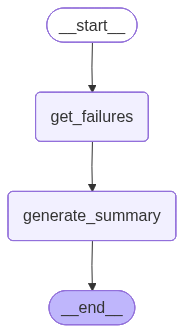

In [7]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# 失败分析（Failure Analysis）子图
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]  # 预处理后的日志（来自父图）
    failures: List[Log]      # 判定为失败的日志子集
    fa_summary: str          # 失败分析的总结
    processed_logs: List[str] # 记录处理过哪些日志的标记

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """获取包含失败信号的日志（例如带有评分/grade 字段的日志）。"""
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """基于失败日志生成总结（此处用占位示例，实际可接入大模型进行摘要）。"""
    failures = state["failures"]
    # 示例：真实项目中可替换为 summarize(failures)
    fa_summary = "检索到的 Chroma 文档质量较差。"
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(state_schema=FailureAnalysisState,output_schema=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

下面是“问题汇总（Question Summarization）”子图，使用 `QuestionSummarizationState` 状态。

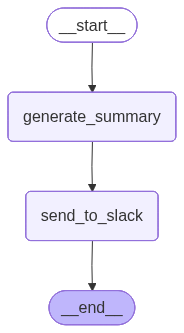

In [8]:
# 问题汇总（Summarization）子图
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]   # 预处理后的日志（来自父图）
    qs_summary: str           # 问题汇总摘要
    report: str               # 面向外部的汇报内容（例如发送到 Slack）
    processed_logs: List[str] # 记录处理过哪些日志的标记

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # 示例：真实项目中可替换为 summary = summarize(cleaned_logs)
    summary = "问题主要聚焦在 ChatOllama 的使用与 Chroma 向量库。"
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # 示例：真实项目中可替换为 report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(QuestionSummarizationState,output_schema=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## 将子图接入父图

现在把它们组合在一起。

我们使用 `EntryGraphState` 定义父图的状态。

然后把两个子图作为节点接入父图：

```
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
```

提示：在 LangGraph 中，把已编译的子图当作“节点”加入到父图，是组织多智能体/多阶段流程的常用方式。

In [9]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log] # 原始输入的日志列表
    cleaned_logs: Annotated[List[Log], add] # 该键会被两个子图读取（作为输入），因此需要一个 reducer 合并并行结果
    fa_summary: str # 仅由失败分析（FA）子图产出
    report: str # 仅由问题汇总（QS）子图产出
    processed_logs:  Annotated[List[int], add] # 两个子图都会写入该键，需要累加器（add）做合并

但是，为什么 `cleaned_logs` 需要一个 reducer（如 `add`）？它只是作为输入传入每个子图，并未被修改。

```
cleaned_logs: Annotated[List[Log], add] # 该键会被两个子图读取（作为输入）
```

原因是：子图在返回其输出状态时，默认会携带**所有键**，即使这些键没有被修改。

当两个子图“并行”运行时，它们会同时把同名键返回给父图。对于这些重名键（例如 `cleaned_logs`），父图需要一个 reducer（如 `operator.add`）来合并来自不同子图的返回值。

不过，我们可以通过给每个子图定义“不同的输出状态（Output State Schema）”来规避这个问题，即让每个子图只对父图发布自己负责的输出键，避免对未修改的键（如 `cleaned_logs`）进行重复发布。

因此，严格来说，我们不需要让每个子图都输出 `cleaned_logs`。

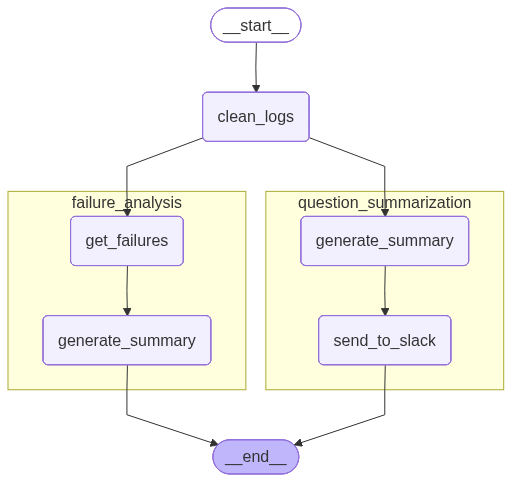

In [11]:
# Entry Graph State 定义
# 定义整个父图的状态结构，它包含从子图接收的信息以及原始输入日志
class EntryGraphState(TypedDict):
    raw_logs: List[Log] # 原始输入的日志列表
    cleaned_logs: List[Log] # 经过预处理（清洗）后的日志列表
    fa_summary: str # 失败分析子图生成的总结（仅由 FA 子图产生）
    report: str # 问题汇总子图生成的外部汇报内容（仅由 QS 子图产生）
    # processed_logs 键会被两个子图同时写入，因此需要使用 Annotated 和 operator.add
    # operator.add 会将来自两个子图的 processed_logs 列表进行合并（累加）
    processed_logs:  Annotated[List[int], add]

# 定义清洗日志的节点函数
def clean_logs(state):
    """
    清洗原始日志数据。
    这个函数接收包含原始日志的状态，并返回一个包含清洗后日志的新状态。
    在实际应用中，这里可以进行数据格式转换、去除无效字段等操作。
    """
    # 从当前状态中获取原始日志
    raw_logs = state["raw_logs"]
    # 数据清洗逻辑：此处简化处理，直接将原始日志作为清洗后的日志
    # 真实场景中，这里是进行 raw_logs 到 cleaned_logs 的转换
    cleaned_logs = raw_logs
    # 返回包含清洗后日志的新状态字典
    return {"cleaned_logs": cleaned_logs}

# 构建主图（Entry Graph）
entry_builder = StateGraph(EntryGraphState)

# 添加节点到主图
# "clean_logs" 节点对应 clean_logs 函数
entry_builder.add_node("clean_logs", clean_logs)
# "question_summarization" 节点对应编译后的问题汇总子图
entry_builder.add_node("question_summarization", qs_builder.compile())
# "failure_analysis" 节点对应编译后的失败分析子图
entry_builder.add_node("failure_analysis", fa_builder.compile())

# 添加边来定义节点之间的流程
# 从 START（图的起始点）到 "clean_logs" 节点
entry_builder.add_edge(START, "clean_logs")
# 从 "clean_logs" 节点并行地连接到 "failure_analysis" 和 "question_summarization" 子图
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
# 从 "failure_analysis" 子图结束到 END（图的终止点）
entry_builder.add_edge("failure_analysis", END)
# 从 "question_summarization" 子图结束到 END（图的终止点）
entry_builder.add_edge("question_summarization", END)

# 编译构建好的图
graph = entry_builder.compile()

from IPython.display import Image, display

# 将 xray 设为 1 可以展示嵌套的子图结构，帮助理解整个图的层次关系
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [13]:
# 示例日志（Dummy logs）
question_answer = Log(
    id="1",
    question="如何导入 ChatOllama?",
    answer="导入方式：from langchain_community.chat_models import ChatOllama",
)

question_answer_feedback = Log(
    id="2",
    question="如何使用 Chroma 向量库?",
    answer="示例：rag_chain = create_retrieval_chain(retriever, question_answer_chain)",
    grade=0,
    grader="Document Relevance Recall",
    feedback="检索到的文档多为通用向量库说明，未聚焦 Chroma 的具体用法",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': '如何导入 ChatOllama?',
   'answer': '导入方式：from langchain_community.chat_models import ChatOllama'},
  {'id': '2',
   'question': '如何使用 Chroma 向量库?',
   'answer': '示例：rag_chain = create_retrieval_chain(retriever, question_answer_chain)',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': '检索到的文档多为通用向量库说明，未聚焦 Chroma 的具体用法'}],
 'cleaned_logs': [{'id': '1',
   'question': '如何导入 ChatOllama?',
   'answer': '导入方式：from langchain_community.chat_models import ChatOllama'},
  {'id': '2',
   'question': '如何使用 Chroma 向量库?',
   'answer': '示例：rag_chain = create_retrieval_chain(retriever, question_answer_chain)',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': '检索到的文档多为通用向量库说明，未聚焦 Chroma 的具体用法'}],
 'fa_summary': '检索到的 Chroma 文档质量较差。',
 'report': 'foo bar baz',
 'processed_logs': ['failure-analysis-on-log-2',
  'summary-on-log-1',
  'summary-on-log-2']}

## LangSmith

查看本例的 LangSmith 追踪：

https://smith.langchain.com/public/f8f86f61-1b30-48cf-b055-3734dfceadf2/r

但是，为什么 `cleaned_logs` 需要一个 reducer（如 `add`）？它只是作为输入传入每个子图，并未被修改。